In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import cvxpy as cp
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

827
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(100):
    plt.close()

In [3]:
# -----------------------------------------------------
# --- Canonical coordinate and some constants ---
# -----------------------------------------------------
xmax_, Nx_ = 4.0, 201

x_ = np.linspace(-xmax_, xmax_, Nx_)
dx_ = np.diff(x_)[0]

# --- Planck constant: h / 2pi, h = 6.6261e−34 J*s ---
hp_ = 1.0 

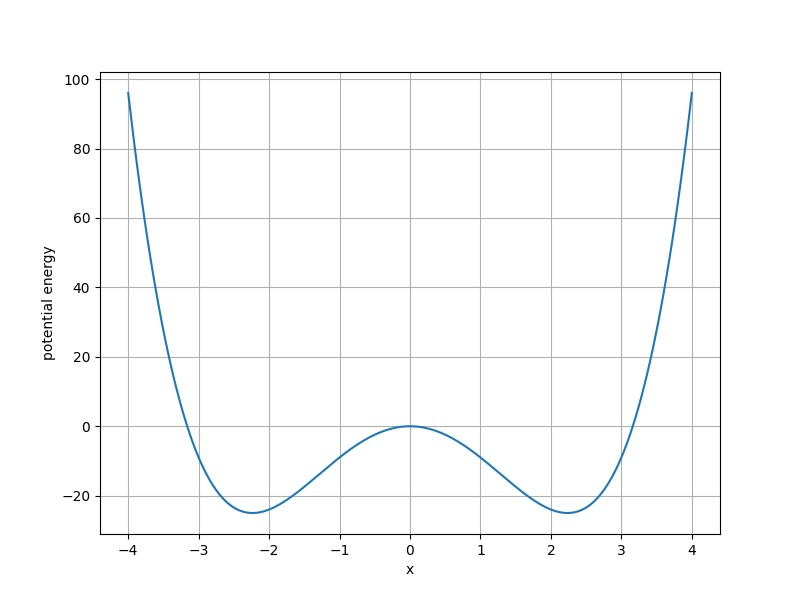

In [27]:
# -----------------------------------------------------
# --- Double-well potential ---
# -----------------------------------------------------
def double_well(x, dx, Nx, m, h2, h4):
    H = np.zeros((Nx, Nx))
    V = np.zeros(Nx) 

    coef0 = hp_**2 / (2.*m * dx**2)

    V_func = lambda x: - 0.5 * h2 * x**2 + 0.25 * h4 * x**4

    for ir in range(Nx):
        # --- Potential ---
        V[ir] = V_func(x[ir])
        # coef1 * x[ir] * x[ir]

        # --- Hamiltonian ---
        if ir == 0:
            H[ir, Nx-1] = -coef0
        else:
            H[ir, ir-1] = -coef0

        if ir == (Nx-1):
            H[ir, 0] = -coef0
        else:
            H[ir, ir+1] = -coef0
        H[ir, ir] = 2. * coef0 + V[ir]

    return H, V, V_func, "harm-osc"
# ---------------------------------------------------------------
m_ = 20.0 # mass
h2_  = 20.0 
h4_ = 4.0

# m_ = 20.0 # mass
# h2_  = 10.0 
# h4_ = 1.0

# m_ = 1.0 # mass
# h2_  = 1.0 
# h4_ = 0.5

H_, V_, V_func_, str_H_ = double_well(x_, dx_, Nx_, m_, h2_, h4_)

# --- Plot potential ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_, V_)
ax.set_xlabel("x")
ax.set_ylabel("potential energy")
ax.grid()
del ax, fig

In [28]:
# ------------------------------------------------------------
# --- Compute eigenvalues and eigenvectors ---
# ------------------------------------------------------------
def compute_eig(H):
    eigVals, eigVecs = np.linalg.eig(H)

    eigVals_sorted = np.sort(eigVals)
    ids_sort = np.argsort(eigVals)

    eigVecs_sorted = eigVecs[:,ids_sort]

    return eigVals_sorted, eigVecs_sorted
# ------------------------------------------------------------
def compute_anharmonicity(eigVals):
    Nx = len(eigVals)
    dw = np.zeros(Nx-1)
    for ix in range(Nx-1):
        dw[ix] = eigVals[ix+1] - eigVals[ix]

    anh = np.zeros(Nx-2)
    for ix in range(Nx-2):
        anh[ix] = dw[ix+1] - dw[ix]    
    return dw, anh
# ------------------------------------------------------------
eigVals_sorted_, eigVecs_sorted_ = compute_eig(H_)
dw_, anh_ = compute_anharmonicity(eigVals_sorted_)
print("Done")

Done


In [29]:
# ------------------------------------------------------------
# --- Print eigenvalues and anharmonicity ---
# ------------------------------------------------------------
def print_eigvals_via_diag_matrix(M, eigVecs_sorted, N_first_eigvals, ff_print):

    # --- matrix diagonalization ---
    Pinv = np.linalg.inv(eigVecs_sorted)
    M_diagonalized = np.dot(np.dot(Pinv, M), eigVecs_sorted)

    # --- extract elements on the main diagonal (eigenvalues) ---
    H_diag_diag = np.diag(M_diagonalized)

    # --- print several first diagonal elements ---
    mix.print_array(H_diag_diag[:N_first_eigvals], ff=ff_print, n_in_row = N_first_eigvals)
    return
# -------------------------------------------------------------------
Ne_print = 20
ff_print = [6, 3, "f"]

print("--- {:d} first eigenvalues ---".format(Ne_print))
mix.print_array(eigVals_sorted_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- {:d} first eigenvalues (via diagonalization) ---".format(Ne_print))
print_eigvals_via_diag_matrix(H_, eigVecs_sorted_, Ne_print, ff_print)

print("\n--- energy differences of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(dw_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- anharmonicity of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(anh_[:Ne_print], ff=[12, 3, "e"], n_in_row = Ne_print)

del Ne_print, ff_print

--- 20 first eigenvalues ---
-24.297 -24.297 -22.906 -22.906 -21.538 -21.538 -20.194 -20.194 -18.872 -18.872 -17.575 -17.575 -16.301 -16.301 -15.052 -15.052 -13.827 -13.827 -12.627 -12.627 

--- 20 first eigenvalues (via diagonalization) ---
-24.297 -24.297 -22.906 -22.906 -21.538 -21.538 -20.194 -20.194 -18.872 -18.872 -17.575 -17.575 -16.301 -16.301 -15.052 -15.052 -13.827 -13.827 -12.627 -12.627 

--- energy differences of first 20 eigenvalues ---
 0.000  1.391  0.000  1.368  0.000  1.345  0.000  1.321  0.000  1.298  0.000  1.274  0.000  1.249  0.000  1.225  0.000  1.200  0.000  1.175 

--- anharmonicity of first 20 eigenvalues ---
   1.391e+00   -1.391e+00    1.368e+00   -1.368e+00    1.345e+00   -1.345e+00    1.321e+00   -1.321e+00    1.298e+00   -1.298e+00    1.274e+00   -1.274e+00    1.249e+00   -1.249e+00    1.225e+00   -1.225e+00    1.200e+00   -1.200e+00    1.175e+00   -1.175e+00 


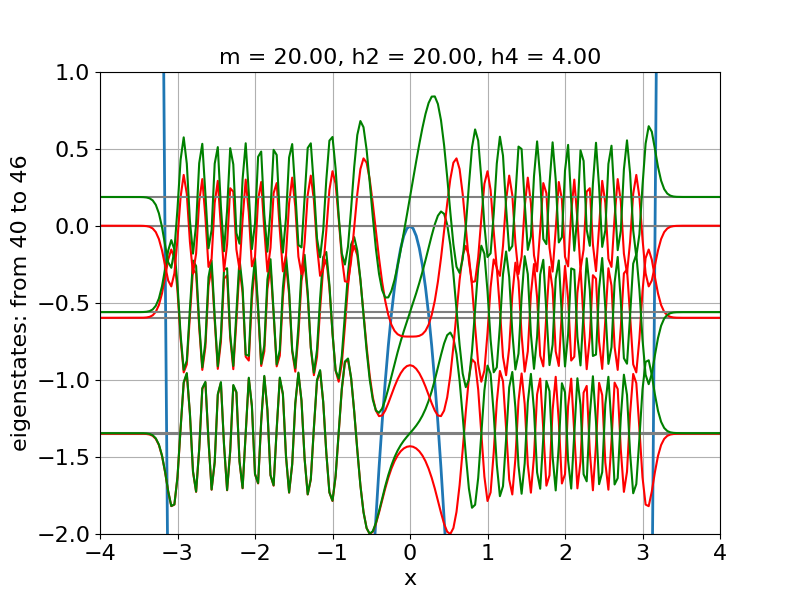

In [30]:
# ------------------------------------------------------------
# --- Plot eigenvalues, anharmonicity and eigenvectors ---
# ------------------------------------------------------------
def plot_eig_anh(id_eig_start, id_eig_end, resc_eigv = 4.0, flag_eigstates = True, ymin = -25, ymax = 2):
    fontsize = 16

    N_eig = id_eig_end - id_eig_start

    # --- Plot eigenvalues and eigenstates ---
    if flag_eigstates:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        ax.plot(x_, V_, "-", linewidth=2)
        for ii in range(id_eig_start, id_eig_end):
            ax.hlines(eigVals_sorted_[ii], -xmax_, xmax_, color="gray")

            color_plot = "green"
            if ii % 2 == 0:
                color_plot = "red"

            eig_vec = resc_eigv * np.array(eigVecs_sorted_[:,ii]) 
            eig_vec += eigVals_sorted_[ii] * np.ones(Nx_) # shift the position of an eigenvector
            ax.plot(x_, eig_vec, "-", color = color_plot)
        ax.set_xlim([-4, 4])
        if ymin is not None:
            ax.set_ylim(ymin = ymin)
            # ax.set_ylim([ymin, 2])
        if ymax is not None:
            ax.set_ylim(ymax=ymax)
        ax.set_xlabel("x", fontsize = fontsize)
        ax.set_ylabel("eigenstates: from {:d} to {:d}".format(id_eig_start, id_eig_end), fontsize = fontsize)
        ax.set_title("m = {:0.2f}, h2 = {:0.2f}, h4 = {:0.2f}".format(m_, h2_, h4_), fontsize = fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.grid()
    return
# ----------------------------------------------------
id_eig_start, N_eig_half, resc_eigv, ymin, ymax = 40, 46, 4.0, -2, 1
# id_eig_start, N_eig_half, resc_eigv, ymin, ymax = 30, 46, 4.0, -6., 2
# id_eig_start, N_eig_half, resc_eigv, ymin, ymax = 0, 46, 4.0, -26, 2

# id_eig_start, N_eig_half, resc_eigv, ymin, ymax = 0, 4, 1.0, -0.5, 10

plot_eig_anh(id_eig_start, N_eig_half, resc_eigv, True, ymin, ymax)

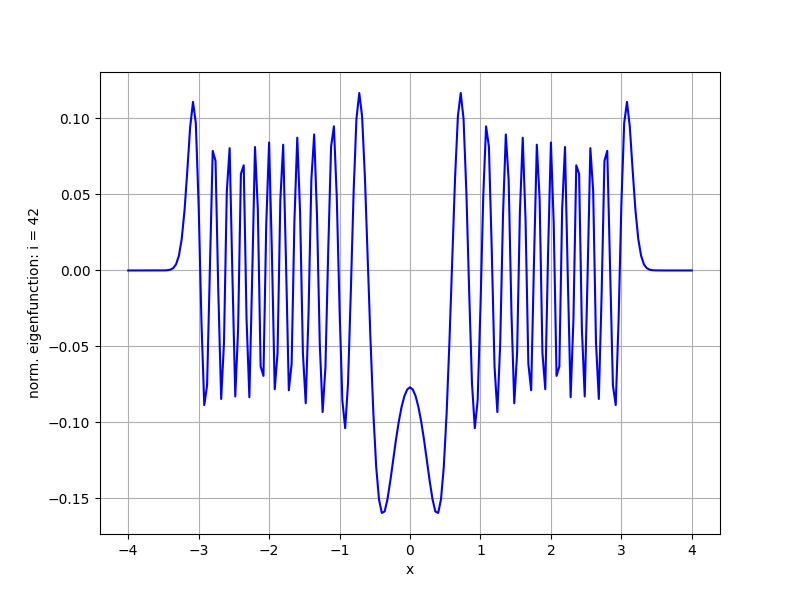

In [58]:
# ------------------------------------------------------------------
# --- Plot separate eigenstates ---
# ------------------------------------------------------------------
import math
def plot_eigfunction(id_to_plot):

    # --- num. function ---
    eigf_num = np.array(eigVecs_sorted_[:,id_to_plot])

    # --- Plotting ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.plot(x_, eigf_num, "-b")
    ax.set_xlabel("x")
    ax.set_ylabel("norm. eigenfunction: i = {:d}".format(id_to_plot))
    ax.grid()
    return
# --------------------------------------------------------------------------
plot_eigfunction(id_to_plot = 42)

In [36]:
# ------------------------------------------------------------------
# --- Construct Wigner quasiprobability ---
# ------------------------------------------------------------------
mix.reload_module(mix)
def Wigner_phase_space(id_to_plot):
    # psi = np.array(eigVecs_sorted_[0:Nx_,id_to_plot])
    psi = np.array(eigVecs_sorted_[:,id_to_plot])

    # Grid for phase space
    p_grid = np.linspace(-40, 40, 4*Nx_)
    
    # Wigner quasiprobability
    W = mix.compute_wigner(psi, x_, p_grid, Nxi = 421, xi_max = 20)
    print("Shape of W: ", np.shape(W))
    return W, p_grid
# --------------------------------------------------------------------------
id_psi_for_Wigner_ = 10
W_, p_ = Wigner_phase_space(id_to_plot = id_psi_for_Wigner_)

Shape of W:  (201, 804)


/media/work/docs/codes/QuCF/scripts-py/pylib/mix.py:1993: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 6))


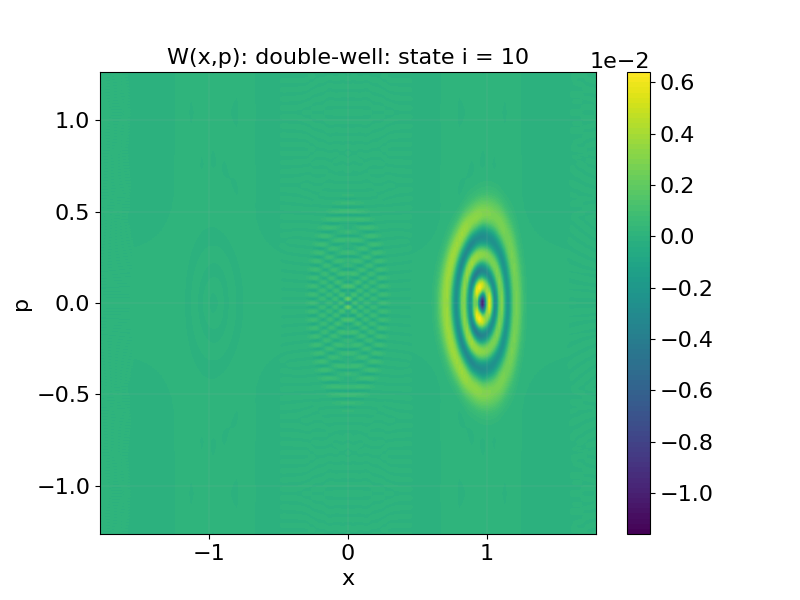

In [37]:
# ------------------------------------------------------------------
# --- Plot Wigner quasiprobability in phase-space ---
# ------------------------------------------------------------------
mix.reload_module(mix)

xvar = x_/np.sqrt(h2_/h4_)
pvar = p_/np.sqrt(m_ * h2_**2 / (2. * h4_))

# xvar = x_
# pvar = p_

mix.plot_Wigner(xvar, pvar, W_, str_for_title = "double-well: state i = {:d}".format(id_psi_for_Wigner_))